In [1]:
import scanpy as sc

In [2]:
adata_wt = sc.read_csv("../data/GSM5359947_D20-3958_WT.csv.gz").T
adata_wt

AnnData object with n_obs × n_vars = 2735 × 31053

In [3]:
adata_ko = sc.read_csv("../data/GSM5359948_D20-3959_KO.csv.gz").T
adata_ko

AnnData object with n_obs × n_vars = 1785 × 31053

In [4]:
adata_wt.obs["treatment"] = "WT"
adata_ko.obs["treatment"] = "KO"

In [5]:
# Labeling mitochondrial genes
adata_wt.var["mt"] = adata_wt.var_names.str.startswith("mt-")
adata_ko.var["mt"] = adata_ko.var_names.str.startswith("mt-")

In [6]:
# calculating metrics
sc.pp.calculate_qc_metrics(adata_wt, qc_vars=["mt"], inplace = True, percent_top=None, log1p=False)
sc.pp.calculate_qc_metrics(adata_ko, qc_vars=["mt"], inplace = True, percent_top=None, log1p=False)

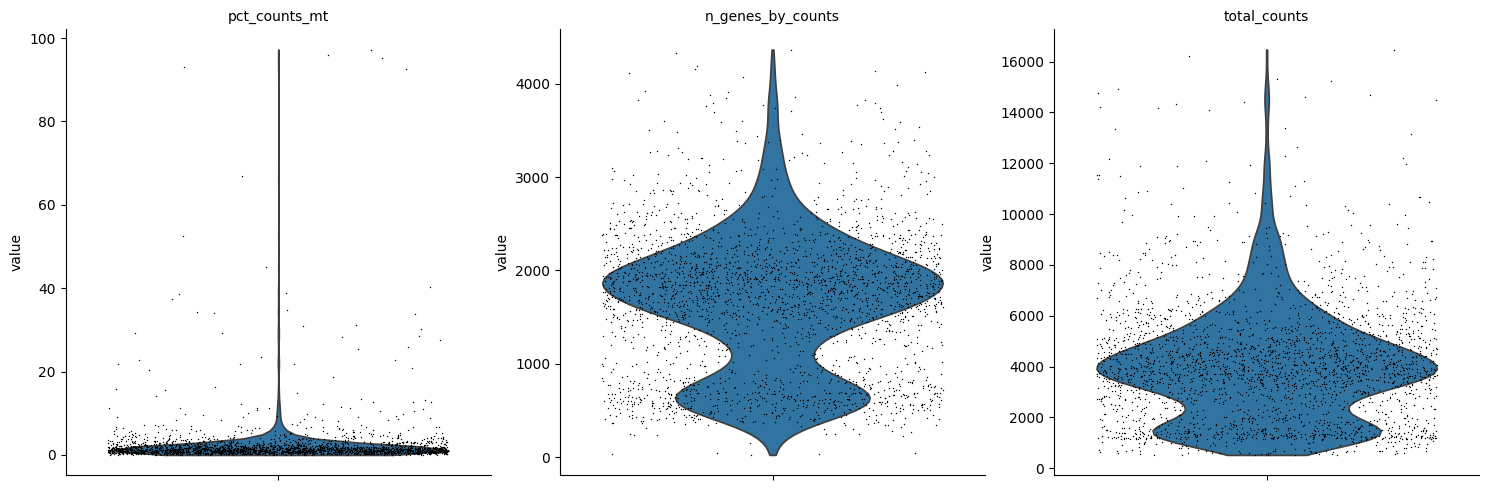

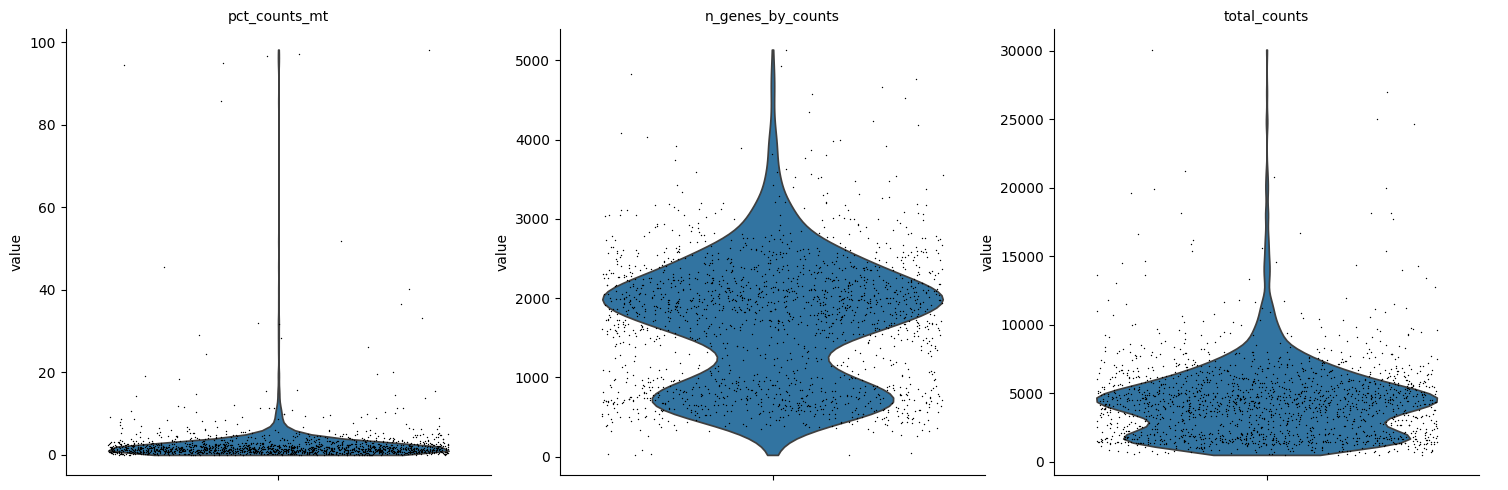

In [7]:
# visualizing mitochondrial percent, genes per cell, and total number of cells
sc.pl.violin(adata_wt, keys = ["pct_counts_mt", "n_genes_by_counts", "total_counts"], multi_panel = True, jitter = 0.4)
sc.pl.violin(adata_ko, keys = ["pct_counts_mt", "n_genes_by_counts", "total_counts"], multi_panel = True, jitter = 0.4)

We want to remove outliers from the data. Cells that have less than 500 genes expressed in them will be filtered out, high mitochondrial percent will be filtered out because it can signify dead cells, and cells with a UMI of less that 1000 will be removed

# Removing outliers

In [8]:
# filtering out cells with less than 500 genes expressed
sc.pp.filter_cells(adata_wt, min_genes = 500)
sc.pp.filter_cells(adata_ko, min_genes = 500)

In [9]:
import doubletdetection

clf = doubletdetection.BoostClassifier(
    n_iters=25, clustering_algorithm="louvain", standard_scaling=True, pseudocount=0.1, n_jobs=-1
)

# doublet identification for wildtype data
doublets = clf.fit(adata_wt.X).predict(p_thresh=1e-7, voter_thresh=0.5)
doublet_score = clf.doublet_score()

adata_wt.obs["doublet"] = doublets

  0%|          | 0/25 [00:00<?, ?it/s]

2024-10-07 15:49:28.193615: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 15:49:28.792282: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 15:49:35.671703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
# doublet identification for knockout data
doublets = clf.fit(adata_ko.X).predict(p_thresh=1e-7, voter_thresh=0.5)
doublet_score = clf.doublet_score()

adata_ko.obs["doublet"] = doublets

  0%|          | 0/25 [00:00<?, ?it/s]

In [11]:
# removing doublets from data
adata_wt = adata_wt[adata_wt.obs.doublet == 0.0]
adata_ko = adata_ko[adata_ko.obs.doublet == 0.0]

In [12]:
# removing high mitochondrial percentage
adata_wt = adata_wt[adata_wt.obs.pct_counts_mt < 10]
adata_ko = adata_ko[adata_ko.obs.pct_counts_mt < 10]

In [13]:
# remove low total UMI counts 
adata_wt = adata_wt[adata_wt.obs["total_counts"] > 1000]
adata_ko = adata_ko[adata_ko.obs["total_counts"] > 1000]

In [14]:
# combining samples for downstream analysis
adata = sc.concat([adata_wt, adata_ko])
adata

/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 4123 × 31053
    obs: 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet'

In [15]:
# labelling mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
adata

AnnData object with n_obs × n_vars = 4123 × 31053
    obs: 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet'
    var: 'mt'

# Normalizing

In [16]:
# adds each column, so each nnumber is for each row
adata.X.sum(axis = 1)

array([3846., 5607., 7221., ..., 5039., 1545., 1490.], dtype=float32)

In [17]:
# normalizing every cell to 10,000 UMI
sc.pp.normalize_total(adata, target_sum = 1e4, exclude_highly_expressed=False) 

In [18]:
adata.X.sum(axis = 1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], dtype=float32)

In [19]:
# log transformation
sc.pp.log1p(adata)

In [20]:
# saving raw counts
adata.raw = adata

In [21]:
adata

AnnData object with n_obs × n_vars = 4123 × 31053
    obs: 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet'
    var: 'mt'
    uns: 'log1p'

# Clustering

In [22]:
# selecting highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True)

/home/kwon.so/.conda/envs/figureOneLab/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [23]:
adata

AnnData object with n_obs × n_vars = 4123 × 3000
    obs: 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet'
    var: 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [24]:
sc.tl.pca(adata, svd_solver= "auto")

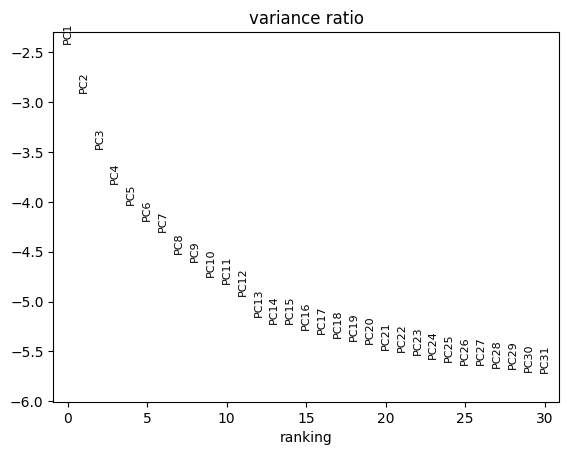

In [52]:
%matplotlib inline
sc.pl.pca_variance_ratio(adata, log = True)

In [45]:
sc.tl.tsne(adata, n_pcs = 15)

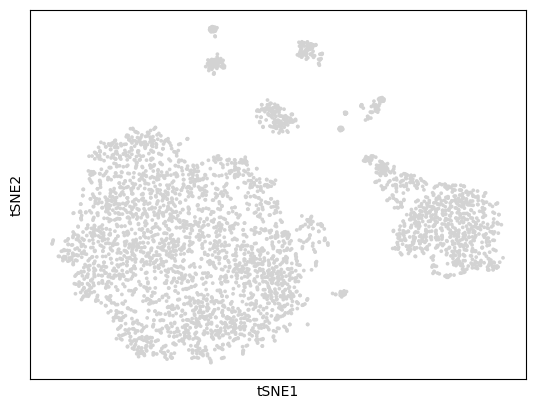

In [53]:
sc.pl.tsne(adata)

In [54]:
sc.pp.neighbors(adata, n_pcs = 15)

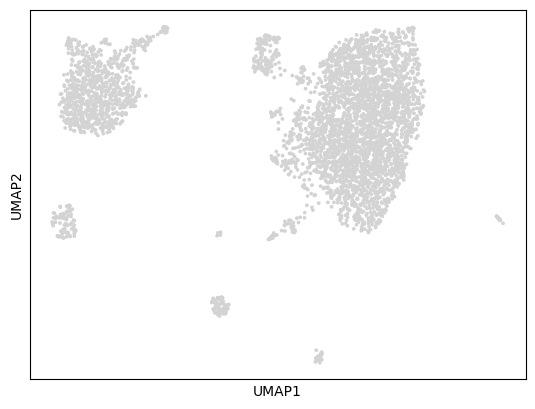

In [55]:
sc.tl.umap(adata)
sc.pl.umap(adata)

In [79]:
# assigning clusters
sc.tl.leiden(adata, resolution = 0.3)

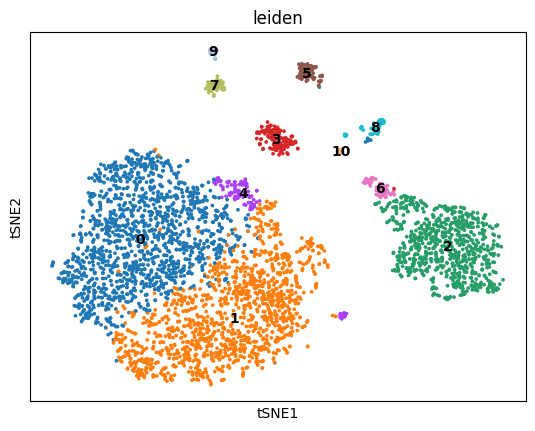

In [81]:
sc.pl.tsne(adata, color = "leiden", legend_loc = "on data")